# Focus Probe

This notebook trys to see what part this model looks at during prediction. 

In [29]:
import torch
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


from model_dataset import ToneDatasetNew as ThisDataset
from model_incremental import *
from model_dataset import TokenMap
from paths import *
from H_1_models import TwoConvNetwork

In [51]:
def grad_cam(model, input_tensor, target_layer, target_class):
    model.eval()  # Set the model to evaluation mode
    
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    hook_b = target_layer.register_backward_hook(backward_hook)
    hook_f = target_layer.register_forward_hook(forward_hook)

    output = model(input_tensor)
    class_score = output[0, target_class]

    model.zero_grad()
    class_score.backward()

    grad = gradients[0].cpu().data.numpy()[0]
    act = activations[0].cpu().data.numpy()[0]

    hook_b.remove()
    hook_f.remove()

    weights = np.mean(grad, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * act, axis=0)

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam) if np.max(cam) != 0 else cam

    return cam

def get_one_batch(dataloader):
    dataloader_iter = iter(dataloader)  # Create an iterator
    batch = next(dataloader_iter)      # Get the first batch
    return batch

def grad_cam_visualization(input_tensor, cam, title="Grad-CAM Heatmap on Test Input"): 
    # Plot the heatmap on the test Mel spectrogram
    plt.imshow(input_tensor.squeeze(0).squeeze(0).cpu().numpy(), aspect='auto', cmap='gray', origin='lower')
    plt.imshow(cam, cmap='jet', alpha=0.3, vmin=0, vmax=1, origin='lower')  # extent=(0, input_tensor.size(-1), 0, input_tensor.size(-2))
    plt.colorbar(label='Importance')
    plt.title(title)
    plt.show()

In [3]:
configs = {
    "num_dataset": 50,
    "size_train": 1600, 
    "size_valid": 320,
    "data_type": "mel",
    "total_epochs": 300, # for lower pre-training conditions we lower the final epoch to 300, because we found no much learning afterwards. 
    "lr": 1e-4,
    "data_type_mapper": {
        "f": "full", 
        "l": "low",
        "h": "high"
    }, 
    "lpp_configs": {
        "p1": 0.5, 
        "decay_rate": 0.3
    }, 
    "max_cache_size_train": 7, 
    "max_cache_size_valid": 20, 
    "output_dim": 4, 
}

In [126]:
# Load validation data: target and full
pretype = "h"
posttype = "f"
train_name = "A3"
ts = "1126125730-1"
model_type = "twoconvCNN"
pre_epoch = 50
total_epoch = 300
selection = "full"


model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
guides_dir = os.path.join(model_save_dir, "guides")
model_save_dir_specific = os.path.join(model_save_dir, f"{model_type}-{pre_epoch}-{total_epoch-pre_epoch}", selection, f"{pretype}{posttype}")

pool_messanger = PoolMessanger(configs["num_dataset"], configs["data_type_mapper"][pretype], configs["data_type_mapper"][posttype], guides_dir)

# NOTE: Subset Cache, this is to manage the reading of datasets. Should be transparent to user. 
valid_cache = SubsetCache(max_cache_size=configs["max_cache_size_valid"], dataset_class=ThisDataset, shuffle=False)
full_valid_cache = SubsetCache(max_cache_size=configs["max_cache_size_valid"], dataset_class=ThisDataset, shuffle=False)

mylist = ["1", "2", "3", "4"]
mymap = TokenMap(mylist)

In [127]:
epoch = 100
# Load Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoConvNetwork()
model.to(device)

model_path = os.path.join(model_save_dir_specific, f"{epoch}.pt")
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.to(device)

TwoConvNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ap): AdaptiveAvgPool2d(output_size=(4, 4))
  (lin_1): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (lin): Linear(in_features=64, out_features=38, bias=True)
)

In [128]:
dataset_id = 0

dataset_id, meta_path, data_path = pool_messanger.get_loading_params(dataset_id,
                                                                    eval_type="valid")
valid_loader = valid_cache.get_subset(dataset_id, meta_path, data_path, mymap, shuffle=False)


dataset_id, meta_path, data_path = pool_messanger.get_loading_params(dataset_id,
                                                                    eval_type="full_valid")
full_valid_loader = full_valid_cache.get_subset(dataset_id, meta_path, data_path, mymap, shuffle=False)

Filtered 30 rows out of 320 from metadata. Now 290 rows remaining.
Filtered 30 rows out of 320 from metadata. Now 290 rows remaining.


In [129]:
valid_mel, valid_tag = valid_loader.dataset.dataset, valid_loader.dataset.gt_set
full_valid_mel, full_valid_tag = full_valid_loader.dataset.dataset, full_valid_loader.dataset.gt_set

In [ ]:


# cam_valid = grad_cam(model, one_valid_mel, target_layer, one_valid_tag)
# cam_full_valid = grad_cam(model, one_full_valid_mel, target_layer, one_full_valid_tag)

# grad_cam_visualization(one_valid_mel, cam_valid, title=f"Grad-CAM Valid {one_valid_tag}")
# grad_cam_visualization(one_full_valid_mel, cam_full_valid, title=f"Grad-CAM Full Valid {one_full_valid_tag}")

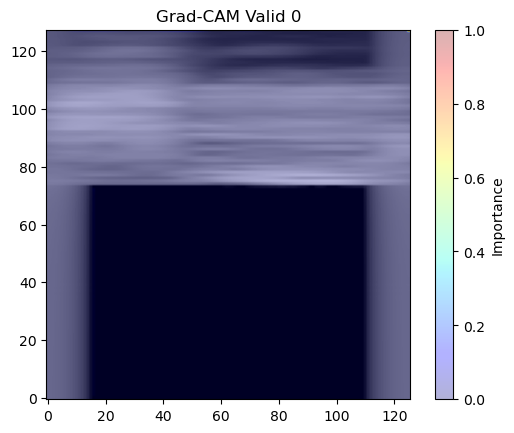

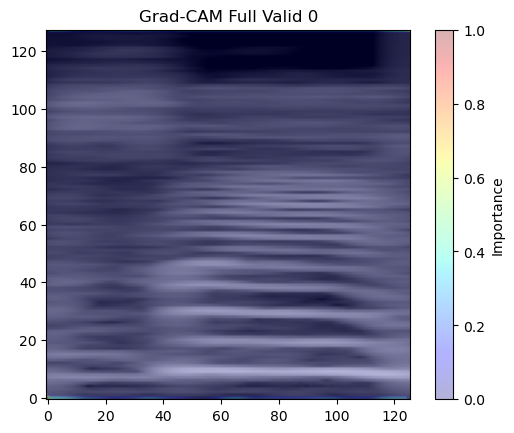

: 

In [ ]:
# Get one randomly
random_idx = np.random.randint(0, len(valid_mel))
one_valid_mel, one_valid_tag = valid_loader.dataset.__getitem__(random_idx)
one_full_valid_mel, one_full_valid_tag = full_valid_loader.dataset.__getitem__(random_idx)

one_valid_mel = one_valid_mel.unsqueeze(0)
one_full_valid_mel = one_full_valid_mel.unsqueeze(0)

# transfer device
one_valid_mel = one_valid_mel.to(device)
one_full_valid_mel = one_full_valid_mel.to(device)

layer_idx = 0

# Grad-CAM valid
input_tensor = one_valid_mel
target_layers = [model.conv[layer_idx]]
targets = [ClassifierOutputTarget(one_valid_tag)]


# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
#   visualization = show_cam_on_image(one_valid_mel[0, 0, :, :], grayscale_cam, use_rgb=False)
    grad_cam_visualization(one_valid_mel, grayscale_cam, title=f"Grad-CAM Valid {one_valid_tag}")
  # You can also get the model outputs without having to redo inference
#   model_outputs = cam.outputs


# Grad-CAM valid
input_tensor = one_full_valid_mel
target_layers = [model.conv[layer_idx]]
targets = [ClassifierOutputTarget(one_full_valid_tag)]


# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    # mel_rgb = generate_rgb_from_mel(one_valid_mel[0, 0, :, :].cpu().numpy())
    # visualization = show_cam_on_image(mel_rgb, grayscale_cam, use_rgb=True)
    grad_cam_visualization(input_tensor, grayscale_cam, title=f"Grad-CAM Full Valid {one_full_valid_tag}")
  # You can also get the model outputs without having to redo inference
#   model_outputs = cam.outputs